# Imports

In [49]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tqdm import tqdm
from time import sleep


# DataLoader

In [18]:
data_dir = 'D:/My Documents/GIT Projects/IEEE-Hack-the-meta/ASL/asl_alphabet_train'
batch_size = 64
validation_split = 0.18
seed = 123

In [24]:
def data_augmentation(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)

    return img, label

def display_examples(dataset, n_examples=5):
    plt.figure(figsize=(20, 20))
    for images, labels in dataset.take(1):
        for i in range(n_examples):
            ax = plt.subplot(1, n_examples, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.show()

In [25]:
train_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=(224, 224),
    batch_size=batch_size,
)

test_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=(224, 224),
    batch_size=batch_size,
)

class_names = train_dataset.class_names
print("Classes:", class_names)

print(f"Number of training batches: {train_dataset.cardinality()}")
print(f"Number of test batches: {test_dataset.cardinality()}")

Found 74646 files belonging to 29 classes.
Using 61210 files for training.
Found 74646 files belonging to 29 classes.
Using 13436 files for validation.
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Number of training batches: 957
Number of test batches: 210


In [28]:
train_dataset = train_dataset.map(data_augmentation, num_parallel_calls=tf.data.experimental.AUTOTUNE)

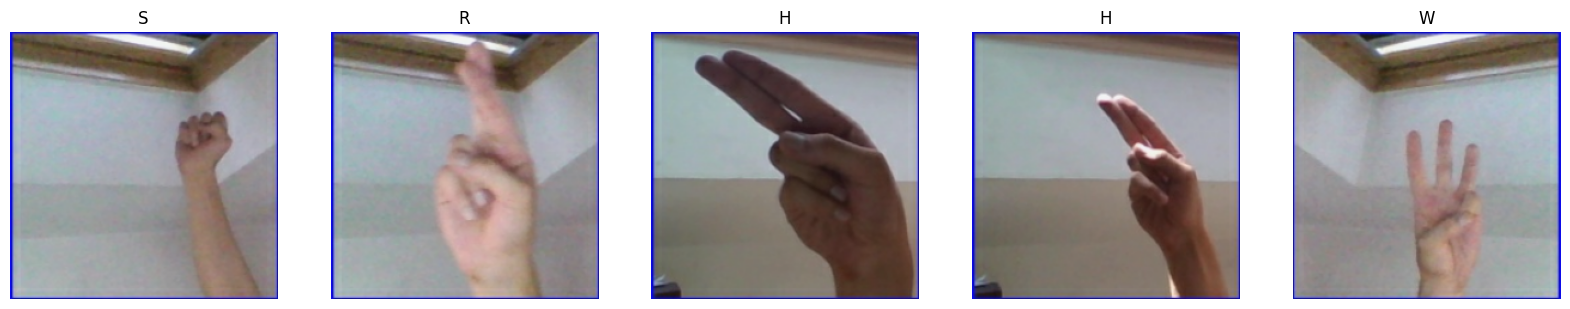

In [33]:
display_examples(train_dataset)

# Model Building

In [34]:
backbone = 'resnet50'
addLayers = False

if backbone == 'resnet50':
    base_model = tf.keras.applications.ResNet50(input_shape=(224,224,3), include_top=False, weights='imagenet')
else:
    base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(len(class_names), activation='softmax')
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 29)                59421     
                                                                 
Total params: 23,647,133
Trainable params: 59,421
Non-trainable params: 23,587,712
_________________________________________________________________


# Loss and Optimizer

In [35]:
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model Training

In [36]:
epochs = 10
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)]
)

Epoch 1/10
957/957 [==============================] - 261s 270ms/step - loss: 0.3403 - accuracy: 0.9296 - val_loss: 0.0964 - val_accuracy: 0.9830
Epoch 2/10
957/957 [==============================] - 287s 298ms/step - loss: 0.0679 - accuracy: 0.9885 - val_loss: 0.0565 - val_accuracy: 0.9895
Epoch 3/10
957/957 [==============================] - 289s 300ms/step - loss: 0.0379 - accuracy: 0.9945 - val_loss: 0.0336 - val_accuracy: 0.9937
Epoch 4/10
957/957 [==============================] - 287s 300ms/step - loss: 0.0250 - accuracy: 0.9961 - val_loss: 0.0279 - val_accuracy: 0.9946
Epoch 5/10
957/957 [==============================] - 289s 301ms/step - loss: 0.0181 - accuracy: 0.9973 - val_loss: 0.0208 - val_accuracy: 0.9957
Epoch 6/10
957/957 [==============================] - 287s 297ms/step - loss: 0.0138 - accuracy: 0.9979 - val_loss: 0.0173 - val_accuracy: 0.9960
Epoch 7/10
957/957 [==============================] - 277s 289ms/step - loss: 0.0110 - accuracy: 0.9983 - val_loss: 0.0173 -

In [41]:
model.save('asl_model_new.h5')

INFO:tensorflow:Assets written to: asl_model\assets


INFO:tensorflow:Assets written to: asl_model\assets


# Run Inference with opencv

In [1]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2
import mediapipe as mp

In [2]:
model = load_model('asl_model_new.h5')

In [3]:
def run_inference(image_path):
    # Load the image
    img = image.load_img(image_path, target_size=(224, 224))
    
    x = image.img_to_array(img)
    
    x = np.expand_dims(x, axis=0)
    
    preds = model.predict(x)
    
    class_id = np.argmax(preds[0])
    class_name = class_names[class_id]
    
    print(f'Predicted Class: {class_name}')

class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

In [6]:
run_inference('D:/My Documents/GIT Projects/IEEE-Hack-the-meta/ASL/asl_alphabet_test/A/A3.jpg')

1/1 [==============================] - 0s 36ms/step
Predicted Class: A


# Run Inference with opencv live

In [7]:
def preprocess_frame(frame):
    frame_resized = cv2.resize(frame, (224, 224))
    
    frame_resized = frame_resized.astype('float32')
    
    frame_resized = np.expand_dims(frame_resized, axis=0)
    
    return frame_resized


In [8]:
cap = cv2.VideoCapture(0)
accumulated_text = ""

import time
last_time = time.time()

cooldown_time = 3.0

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)


while True:
    ret, frame = cap.read()
    
    if not ret:
        break
    
    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)
    
    frame_preprocessed = preprocess_frame(frame)
    
    preds = model.predict(frame_preprocessed)
    class_id = np.argmax(preds[0])
    class_name = class_names[class_id]
    
    current_time = time.time()
    if current_time - last_time >= cooldown_time:
        if class_name == 'del':
            accumulated_text = accumulated_text[:-1]
        elif class_name == 'space':
            accumulated_text += ' '
        elif class_name != 'nothing':
            accumulated_text += class_name
        
        last_time = current_time

    cv2.putText(frame, f'Predicted Class: {class_name}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    print(accumulated_text)
    
    cv2.imshow('ASL Recognition', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 30ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 30ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 29ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 36ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 26ms